In [1]:
import pandas as pd
import sqlalchemy as sql
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# Import

In [2]:

# read password and user to database
credentials_file = r'credentials.pw'

credentials = pd.read_csv(credentials_file, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]

host="twofast-rpi3-0"  # your host
user=user # username
passwd=pw  # password
db="FNL" # name of the database
connect_string = 'mysql+pymysql://%(user)s:%(pw)s@%(host)s:3306/%(db)s'% {"user": user, "pw": pw, "host": host, "db": db}
sql_engine = sql.create_engine(connect_string)

# Plot pressure

In [3]:
# get data
query = f"SELECT * FROM live_pressure;"
df_pr = pd.read_sql(query, sql_engine)

In [4]:
# pressure calibration
# correct the pressure that the arduino reads. This is done using the dose_lookup_table which relates the pi dose with the displayed dose.
df_LT_pressure = pd.read_csv(f"/Users/hkromer/02_PhD/01.github/FNL_Neutron_Generator_Control/03.Dash/01.V1/calibration/LUT_pressure_ion_source.txt", delimiter="\t")

# interpolation function
interp_pressure_IS = interp1d(pd.to_numeric(df_LT_pressure['pressure_IS_pi']).values, pd.to_numeric(df_LT_pressure['pressure_IS_display']).values, fill_value='extrapolate')


# conversion
df_pr['pressure_IS'] = 10**(1.667*df_pr['voltage_IS']-11.33)
df_pr['pressure_IS'] = interp_pressure_IS(df_pr['pressure_IS'])

In [5]:
# select date
start = '2020-10-14 09:00:00'
end = '2020-10-15 18:30:00'

df_pr_time = df_pr[ (df_pr['time'] < end) & (df_pr['time'] > start) ]
df_pr_time = df_pr_time.set_index('time')

# plt.figure()
# plt.plot(df_pr_time.index, df_pr_time['pressure_IS'])
# plt.scatter(df_pr_time.index, df_pr_time['pressure_IS'])
# plt.yscale('log')
# plt.ylim(1e-7, 1e-1)
# plt.ylabel("Pressure [mbar]")
# plt.show()

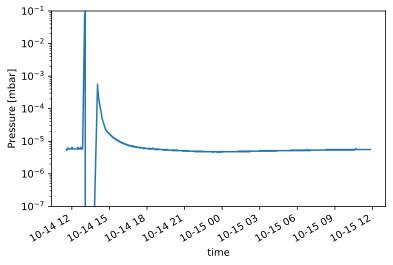

In [6]:
plt.figure()
df_pr_time['pressure_IS'].plot()
plt.yscale('log')
plt.ylim(1e-7, 1e-1)
plt.ylabel("Pressure [mbar]")
plt.show()

# Plot HV and dose

In [51]:
query = f"SELECT * FROM live_hv_dose;"
df_hv = pd.read_sql(query, sql_engine)
df_hv

,id,experiment_id,time,HV_voltage,HV_current,dose_voltage
0,1,15,2020-09-22 10:23:34,98.1429,0.390476,1.90
1,2,15,2020-09-22 10:23:35,98.1429,0.390476,1.90
2,3,15,2020-09-22 10:23:36,98.1429,0.390476,1.90
3,4,15,2020-09-22 10:23:37,98.1429,0.390476,1.90
4,5,15,2020-09-22 10:23:38,98.1429,0.390476,1.90
...,...,...,...,...,...,...
113610,113612,20,2020-10-14 13:25:56,0.0000,0.000000,0.09
113611,113613,20,2020-10-14 13:25:57,0.0000,0.000000,0.09
113612,113614,20,2020-10-14 13:25:58,0.0000,0.000000,0.07
113613,113615,20,2020-10-14 13:25:59,0.0000,0.000000,0.07


In [55]:
# HV calibration
df_HV_LT = pd.read_csv(f'/Users/hkromer/02_PhD/01.github/FNL_Neutron_Generator_Control/03.Dash/01.V1/calibration/HV_readout_calibration.txt', delimiter="\t")
interp_HV_voltage = interp1d(df_HV_LT['Voltage_read'], df_HV_LT['HV_voltage'], fill_value="extrapolate")
# hv calibration
df_hv['HV_voltage'] = interp_HV_voltage(df_hv['HV_voltage'].values)

In [56]:
# select date
start = '2020-10-14 08:00:00'
end = '2020-10-14 13:30:00'

df_hv_time = df_hv[ (df_hv['time'] < end) & (df_hv['time'] > start) ]
df_hv_time = df_hv_time.set_index('time')

# plt.figure()
# plt.plot(df_pr_time.index, df_pr_time['pressure_IS'])
# plt.scatter(df_pr_time.index, df_pr_time['pressure_IS'])
# plt.yscale('log')
# plt.ylim(1e-7, 1e-1)
# plt.ylabel("Pressure [mbar]")
# plt.show()

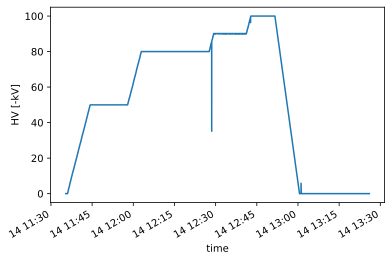

In [58]:
plt.figure()
df_hv_time['HV_voltage'].plot()
# plt.yscale('log')
# plt.ylim(1e-7, 1e-1)
plt.ylabel("HV [-kV]")
plt.show()